In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import os
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pickle

2024-04-13 03:17:52.339103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 03:17:52.339249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 03:17:52.475542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [4]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.10, random_state=42,stratify=x_train[['label']])

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_width, img_height = 64,64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())

train_datagen = ImageDataGenerator(rescale=1/255.0)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale=1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)

holdout_datagen = ImageDataGenerator(rescale=1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)


Found 70470 validated image filenames belonging to 29 classes.
Found 7830 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


MOBILENET

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.layers import DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D

model = Sequential()

# Entry Flow
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Middle Flow
for _ in range(4):
    model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())

# Exit Flow
model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

# Output layer
model.add(Dense(29, activation='softmax'))

model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 64, 64, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 32, 32, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 16, 16, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 16, 16, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        16,51

 Total params: 132,125 (516.11 KB)

 Trainable params: 128,669 (502.61 KB)

 Non-trainable params: 3,456 (13.50 KB)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=8

history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-13 03:28:27.545329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.52205, expected 2.04843
2024-04-13 03:28:27.545406: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1280: 3.68618, expected 3.21256
2024-04-13 03:28:27.545444: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8192: 2.56124, expected 1.61154
2024-04-13 03:28:27.545452: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8193: 4.15056, expected 3.20085
2024-04-13 03:28:27.545460: E external/local_xla/xla/service/gpu/buffer_compar

  2/276 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.0332 - loss: 3.4029   

I0000 00:00:1712978920.218831      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/276 ━━━━━━━━━━━━━━━━━━━━ 3:46 1s/step - accuracy: 0.3528 - loss: 2.3272

2024-04-13 03:31:35.726587: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.43261, expected 2.8373
2024-04-13 03:31:35.726640: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.93246, expected 4.33714
2024-04-13 03:31:35.726651: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43: 4.88195, expected 4.28664
2024-04-13 03:31:35.726661: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.64353, expected 4.04821
2024-04-13 03:31:35.726670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.9248, expected 2.32948
2024-04-13 03:31:35.726680: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64: 4.29544, expected 3.70013
2024-04-13 03:31:35.726689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 127: 3.8003, expected 3.20498
2024-04-13 03:31:35.726699: E external/local_xla/xla

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5709 - loss: 1.5782

2024-04-13 03:36:04.879000: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8255: 2.21789, expected 1.79619
2024-04-13 03:36:04.879065: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9344: 3.15744, expected 2.73574
2024-04-13 03:36:04.879084: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11839: 3.15087, expected 2.72917
2024-04-13 03:36:04.879094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12224: 3.15142, expected 2.72972
2024-04-13 03:36:04.879102: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12256: 3.13556, expected 2.71386
2024-04-13 03:36:04.879110: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12261: 2.84217, expected 2.42047
2024-04-13 03:36:04.879118: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12287: 2.3471, expected 1.9254
2024-04-13 03:36:04.879161: E e

276/276 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.5718 - loss: 1.5751 - val_accuracy: 0.0345 - val_loss: 4.3380
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 99s 349ms/step - accuracy: 0.9952 - loss: 0.0390 - val_accuracy: 0.0475 - val_loss: 7.7168
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 100s 352ms/step - accuracy: 0.9998 - loss: 0.0077 - val_accuracy: 0.9986 - val_loss: 0.0144
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 101s 359ms/step - accuracy: 0.9999 - loss: 0.0026 - val_accuracy: 0.9513 - val_loss: 0.1425
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 100s 353ms/step - accuracy: 0.9960 - loss: 0.0186 - val_accuracy: 0.8852 - val_loss: 0.3918
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 98s 347ms/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 0.9996 - val_loss: 0.0028
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 100s 354ms/step - accuracy: 1.0000 - loss: 5.2546e-04 - val_accuracy: 1.0000 - val_loss: 6.4868e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 102s 360ms/step - accuracy: 1.0000 - loss: 2

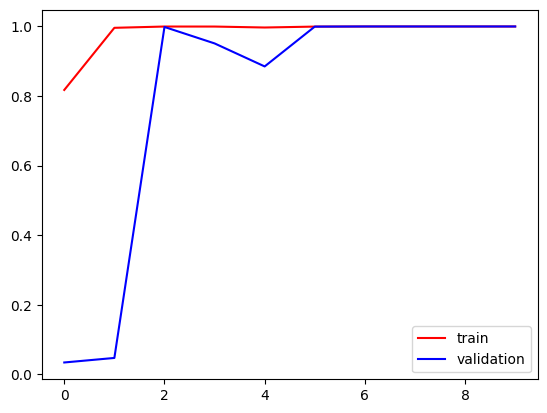

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

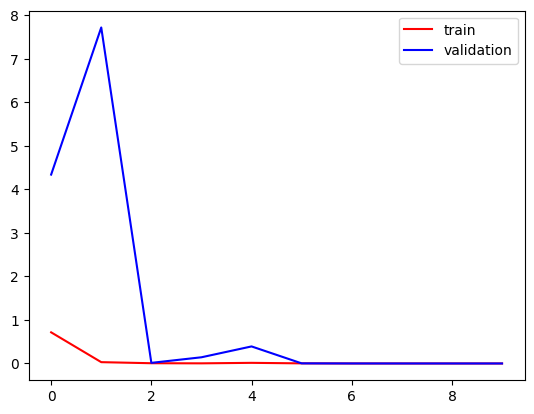

In [10]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Define path to test folder
test_data_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
# Load and preprocess test data
x_test, y_test = load_images_from_folder(test_data_dir)
x_test = x_test.astype('float32') / 255
y_test = to_categorical(y_test, NUM_CLASSES)

# Evaluate the model on test data
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
# print(f'Overall test accuracy: {test_acc:.4f}')
print("test accuracy",test_acc)
print(test_acc*100)

In [22]:
import os
import cv2
import numpy as np



test_folder = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'  # Update with the path to your directory

# Load and preprocess test data
x_test = []
y_test = []

# Iterate through each image in the testing folder
for filename in os.listdir(test_folder):
    img_path = os.path.join(test_folder, filename)
    if os.path.isfile(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (64, 64))  # Resize image to match model input shape
            x_test.append(img_resized.astype('float32') / 255)
            # Extract label from filename (assuming filename format: label_image.jpg)
            label = filename.split('_')[0]
            y_test.append(str(label))  # Assuming labels are named numerically (0, 1, 2, ..., 28)

# Convert lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)
predictions = model.predict(x_test)
# predicted_labels = np.argmax(predictions, axis=1)
from sklearn.metrics import accuracy_score,classification_report
# Convert predicted labels to strings
predicted_labels_str = [str(label) for label in predicted_labels]

# Calculate additional evaluation metrics
classification_rep = classification_report(y_test, predicted_labels_str)

print("Classification Report:")
print(classification_rep)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


ValueError: Found input variables with inconsistent numbers of samples: [28, 840]

In [ ]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
model_json = model.to_json()
with open("aslrecognition.json",'w') as json_file:
    json_file.write(model_json)
model.save("aslrecognitionmodel.h5")
model.save_weights("aslrecognition.weights.h5")

DENSENET

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications.densenet import DenseNet121

# Input shape
input_shape = (64, 64, 3)
num_classes = 29  # Assuming you have 29 classes

# Create the DenseNet model (excluding the top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[early_stop])


In [29]:
# Evaluate the model on the test # Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate()

# Print the test accuracy
print("Test Accuracy:", test_accuracy)




ValueError: Unrecognized data type: x=<keras.src.legacy.preprocessing.image.ImageDataGenerator object at 0x7ff9cdd29f90> (of type <class 'keras.src.legacy.preprocessing.image.ImageDataGenerator'>)

In [14]:
import os
import cv2
import numpy as np

test_folder = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'  # Update with the path to your directory

# Load and preprocess test data
x_test = []
y_test = []

# Iterate through each image in the testing folder
for filename in os.listdir(test_folder):
    img_path = os.path.join(test_folder, filename)
    if os.path.isfile(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (64, 64))  # Resize image to match model input shape
            x_test.append(img_resized.astype('float32') / 255)
            # Extract label from filename (assuming filename format: label_image.jpg)
            label = filename.split('_')[0]
            y_test.append(str(label))  # Assuming labels are named numerically (0, 1, 2, ..., 28)

# Convert lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)
